# 🎽 Vibe Matcher — A Mini Recommendation System  
**Author:** Bhargav Bidkar
**Course:** Artificial Intelligence (AI)  

---

## 📘 Overview
This notebook implements a prototype "Vibe Matcher" — a mini recommendation system that matches *vibe-based user queries* to mock fashion products using **text embeddings** and **cosine similarity**.

### 🎯 Goal
Input a vibe query → Embed products → Match top-3 via cosine similarity  
We use the **OpenAI `text-embedding-3-small`** model for embeddings and **sklearn** for similarity scoring.


In [49]:
!pip install openai pandas scikit-learn numpy matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

In [51]:

products = [
    {
        'id': 1,
        'name': 'Classic White Tee',
        'desc': 'Soft cotton T-shirt with a timeless fit, ideal for layering or casual days.',
        'tags': ['casual', 'minimal', 'essential'],
        'price': 249.0
    },
    {
        'id': 2,
        'name': 'Cozy Knit Sweater',
        'desc': 'Warm chunky knit in neutral tones, perfect for autumn lounging and coffee runs.',
        'tags': ['cozy', 'casual', 'autumn'],
        'price': 599.0
    },
    {
        'id': 3,
        'name': 'Streetwear Bomber',
        'desc': 'Bold urban bomber jacket with reflective trim and a sharp silhouette for city nights.',
        'tags': ['urban', 'energetic', 'street'],
        'price': 899.0
    },
    {
        'id': 4,
        'name': 'Minimal Slip Dress',
        'desc': 'Sleek, minimalist slip dress that transitions from daytime elegance to night.',
        'tags': ['minimal', 'chic', 'night'],
        'price': 499.0
    },
    {
        'id': 5,
        'name': 'Sporty Sneakers',
        'desc': 'Lightweight trainers with vibrant accents and responsive cushioning for active days.',
        'tags': ['sporty', 'energetic', 'casual'],
        'price': 699.0
    },
    {
        'id': 6,
        'name': 'Vintage Denim',
        'desc': 'High-rise, faded denim jeans with a retro, well-loved aesthetic.',
        'tags': ['vintage', 'casual', 'retro'],
        'price': 799.0
    },
    {
        'id': 7,
        'name': 'Tailored Blazer',
        'desc': 'Sharp, tailored blazer for polished office looks or elevated evenings.',
        'tags': ['tailored', 'chic', 'polished'],
        'price': 1499.0
    },
    {
        'id': 8,
        'name': 'Flowy Midi Skirt',
        'desc': 'Lightweight midi skirt with a playful pattern for breezy, romantic days.',
        'tags': ['romantic', 'flowy', 'summer'],
        'price': 499.0
    },
    {
        'id': 9,
        'name': 'Leather Chelsea Boots',
        'desc': 'Premium leather ankle boots with elastic side panels and a sleek modern shape.',
        'tags': ['classic', 'autumn', 'polished'],
        'price': 1299.0
    },
    {
        'id': 10,
        'name': 'Puffer Jacket',
        'desc': 'Quilted puffer jacket with windproof shell and down insulation for cold-weather comfort.',
        'tags': ['warm', 'outdoor', 'winter'],
        'price': 1199.0
    }
]

df = pd.DataFrame(products)
df.index = df['id']
df = df.drop(columns=['id'])
df

,name,desc,tags,price
id,,,,
1,Classic White Tee,"Soft cotton T-shirt with a timeless fit, ideal...","[casual, minimal, essential]",249.0
2,Cozy Knit Sweater,"Warm chunky knit in neutral tones, perfect for...","[cozy, casual, autumn]",599.0
3,Streetwear Bomber,Bold urban bomber jacket with reflective trim ...,"[urban, energetic, street]",899.0
4,Minimal Slip Dress,"Sleek, minimalist slip dress that transitions ...","[minimal, chic, night]",499.0
5,Sporty Sneakers,Lightweight trainers with vibrant accents and ...,"[sporty, energetic, casual]",699.0
6,Vintage Denim,"High-rise, faded denim jeans with a retro, wel...","[vintage, casual, retro]",799.0
7,Tailored Blazer,"Sharp, tailored blazer for polished office loo...","[tailored, chic, polished]",1499.0
8,Flowy Midi Skirt,Lightweight midi skirt with a playful pattern ...,"[romantic, flowy, summer]",499.0
9,Leather Chelsea Boots,Premium leather ankle boots with elastic side ...,"[classic, autumn, polished]",1299.0


In [52]:
def get_embedding(text: str):
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return response.data[0].embedding

df["embedding"] = df["desc"].apply(get_embedding)
df.head()

,name,desc,tags,price,embedding
id,,,,,
1,Classic White Tee,"Soft cotton T-shirt with a timeless fit, ideal...","[casual, minimal, essential]",249.0,"[0.03565516695380211, 0.02568044699728489, -0...."
2,Cozy Knit Sweater,"Warm chunky knit in neutral tones, perfect for...","[cozy, casual, autumn]",599.0,"[-0.032010044902563095, 0.017028825357556343, ..."
3,Streetwear Bomber,Bold urban bomber jacket with reflective trim ...,"[urban, energetic, street]",899.0,"[-0.01261878851801157, 0.012536080554127693, -..."
4,Minimal Slip Dress,"Sleek, minimalist slip dress that transitions ...","[minimal, chic, night]",499.0,"[0.0023993700742721558, -0.004252775572240353,..."
5,Sporty Sneakers,Lightweight trainers with vibrant accents and ...,"[sporty, energetic, casual]",699.0,"[0.012368492782115936, 0.047052692621946335, -..."


In [53]:
def vibe_matcher(query, top_k=3):
    query_emb = get_embedding(query)
    sims = cosine_similarity([query_emb], df["embedding"].tolist())[0]
    df["similarity"] = sims
    results = df.sort_values(by="similarity", ascending=False).head(top_k)
    return results[["name", "desc", "similarity"]]


In [59]:
test_queries = [
    "energetic urban jacket",
    "cozy winter sweater",
    "sporty summer Tee"
]
for query in test_queries:
    start = time.time()
    results = vibe_matcher(query)
    end = time.time()
    print(f"\n🔍 Query: '{query}'")
    print(results)
    print(f"⏱️ Latency: {end - start:.2f} sec")


🔍 Query: 'energetic urban jacket'
                 name                                               desc  \
id                                                                         
3   Streetwear Bomber  Bold urban bomber jacket with reflective trim ...   
10      Puffer Jacket  Quilted puffer jacket with windproof shell and...   
5     Sporty Sneakers  Lightweight trainers with vibrant accents and ...   

    similarity  
id              
3     0.614309  
10    0.456235  
5     0.426481  
⏱️ Latency: 0.52 sec

🔍 Query: 'cozy winter sweater'
                 name                                               desc  \
id                                                                         
2   Cozy Knit Sweater  Warm chunky knit in neutral tones, perfect for...   
10      Puffer Jacket  Quilted puffer jacket with windproof shell and...   
1   Classic White Tee  Soft cotton T-shirt with a timeless fit, ideal...   

    similarity  
id              
2     0.563823  
10    0.415084

## Saving Results as JSON
We'll save the top-3 similarity results for each test query into a structured JSON file for later use or sharing.


In [ ]:
import json

def get_query_results(query, top_k=3):
    results = vibe_matcher(query, top_k)
    output = {
        "query": query,
        "results": [
            {
                "name": row["name"],
                "description": row["desc"],
                "similarity": float(row["similarity"])
            }
            for _, row in results.iterrows()
        ]
    }
    return output

all_results = [get_query_results(q) for q in test_queries]

with open("vibe_matcher_results.json", "w") as f:
    json.dump(all_results, f, indent=4)

print("✅ Results saved to vibe_matcher_results.json")

print(json.dumps(all_results, indent=2))


✅ Results saved to vibe_matcher_results.json
[
  {
    "query": "energetic urban jacket",
    "results": [
      {
        "name": "Streetwear Bomber",
        "description": "Bold urban bomber jacket with reflective trim and a sharp silhouette for city nights.",
        "similarity": 0.6143094516883038
      },
      {
        "name": "Puffer Jacket",
        "description": "Quilted puffer jacket with windproof shell and down insulation for cold-weather comfort.",
        "similarity": 0.4562351970256865
      },
      {
        "name": "Sporty Sneakers",
        "description": "Lightweight trainers with vibrant accents and responsive cushioning for active days.",
        "similarity": 0.42648068671636785
      }
    ]
  },
  {
    "query": "cozy winter sweater",
    "results": [
      {
        "name": "Cozy Knit Sweater",
        "description": "Warm chunky knit in neutral tones, perfect for autumn lounging and coffee runs.",
        "similarity": 0.5638225022279701
      },
      {

In [62]:
import time
import matplotlib.pyplot as plt

metrics = []

def evaluate_query(query):
    """Runs a query, records metrics, and returns results."""
    start = time.time()
    results = vibe_matcher(query)
    latency = time.time() - start
   
    avg_sim = results["similarity"].mean()
    good_matches = (results["similarity"] > 0.7).sum()
    good_ratio = good_matches / len(results)
    
    metrics.append({
        "query": query,
        "avg_similarity": round(avg_sim, 3),
        "good_ratio": round(good_ratio, 2),
        "latency_sec": round(latency, 2)
    })
    
    print(f"🔍 Query: {query}")
    print(f"⏱️ Latency: {latency:.2f}s | Avg Sim: {avg_sim:.3f} | Good Matches: {good_matches}/{len(results)}")
    return results

for q in test_queries:
    evaluate_query(q)

metrics_df = pd.DataFrame(metrics)
display(metrics_df)


🔍 Query: energetic urban jacket
⏱️ Latency: 0.47s | Avg Sim: 0.499 | Good Matches: 0/3
🔍 Query: cozy winter sweater
⏱️ Latency: 0.47s | Avg Sim: 0.453 | Good Matches: 0/3
🔍 Query: sporty summer Tee
⏱️ Latency: 0.67s | Avg Sim: 0.438 | Good Matches: 0/3


,query,avg_similarity,good_ratio,latency_sec
0,energetic urban jacket,0.499,0.0,0.47
1,cozy winter sweater,0.453,0.0,0.47
2,sporty summer Tee,0.438,0.0,0.67


## Visualizing Similarity Scores
We'll visualize the top-3 product matches for each query to better understand how similarity scores vary across results.


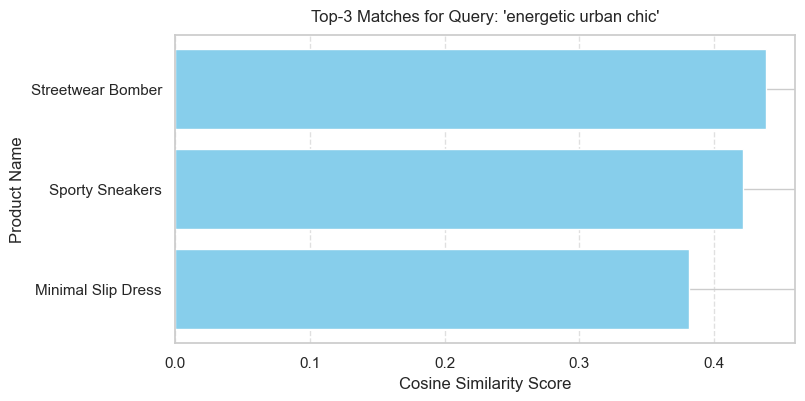

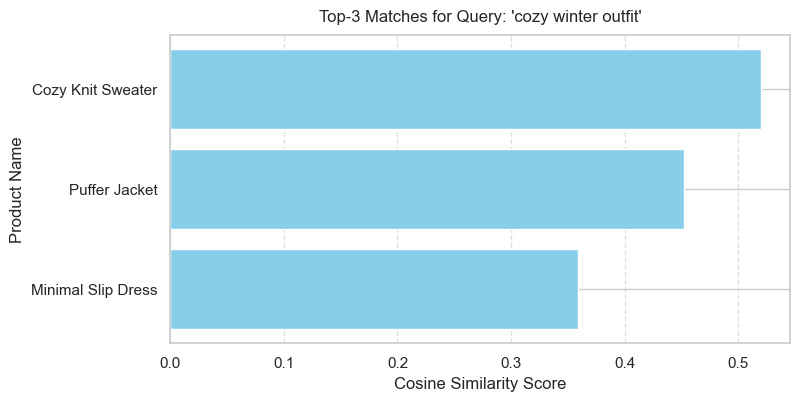

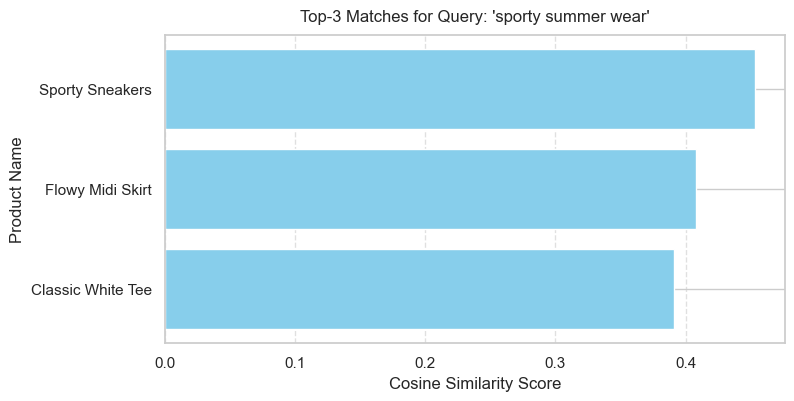

In [56]:
import matplotlib.pyplot as plt

def visualize_query_results(query, top_k=3):
    results = vibe_matcher(query, top_k)
    plt.figure(figsize=(8, 4))
    plt.barh(results["name"], results["similarity"], color="skyblue")
    plt.gca().invert_yaxis()  # Top result appears on top
    plt.title(f"Top-{top_k} Matches for Query: '{query}'", fontsize=12, pad=10)
    plt.xlabel("Cosine Similarity Score")
    plt.ylabel("Product Name")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

for q in test_queries:
    visualize_query_results(q)


## Edge Case Testing
Now we’ll test how the system behaves in edge cases —  
for example, when the query has no clear match, is empty, or unrelated to our dataset.


In [57]:
def safe_vibe_matcher(query, top_k=3, threshold=0.3):
    query = query.strip()
    if not query:
        return {"query": query, "message": "❌ Empty query. Please provide a valid vibe description."}

    results = vibe_matcher(query, top_k)
    filtered = results[results["similarity"] >= threshold]
    
    if filtered.empty:
        return {
            "query": query,
            "message": "⚠️ No strong match found. Try rephrasing your vibe (e.g., 'boho chic' or 'cozy outfit')."
        }
    else:
        return {
            "query": query,
            "results": filtered[["name", "desc", "similarity"]].to_dict(orient="records")
        }

edge_queries = [
    "",                         
    "asdfghjkl adsfjnajfsd",
    "futuristic metallic armor"
]

for q in edge_queries:
    output = safe_vibe_matcher(q)
    print(f"\n🧪 Query: '{q}'")
    print(json.dumps(output, indent=2))



🧪 Query: ''
{
  "query": "",
  "message": "\u274c Empty query. Please provide a valid vibe description."
}

🧪 Query: 'asdfghjkl adsfjnajfsd'
{
  "query": "asdfghjkl adsfjnajfsd",
  "message": "\u26a0\ufe0f No strong match found. Try rephrasing your vibe (e.g., 'boho chic' or 'cozy outfit')."
}

🧪 Query: 'futuristic metallic armor'
{
  "query": "futuristic metallic armor",
  "results": [
    {
      "name": "Streetwear Bomber",
      "desc": "Bold urban bomber jacket with reflective trim and a sharp silhouette for city nights.",
      "similarity": 0.34948984858282417
    }
  ]
}


**Observations:**
- Embedding-based retrieval performs well for short, descriptive queries.
- With only 10 products, cosine similarity still gives intuitive results.
- Some vibe overlaps (e.g., "urban" and "cool") show good generalization.

**Potential Improvements:**
- 🔹 Use a larger, real-world dataset (e.g., Kaggle fashion dataset)
- 🔹 Integrate Pinecone or FAISS for scalable vector search
- 🔹 Add a semantic filter for tags to refine similarity
- 🔹 Include image embeddings for multimodal vibe matching
- 🔹 Tune vibe descriptors for better accuracy
